# Comparison of filters: KF, UFK and PF in three models

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import linalg

np.random.seed(123)

## `StateSpaceModel` class

In [ ]:


class StateSpaceModel:
    """
    Class for discrete space state models:
        x_{k+1} = f(x_{k}, theta) + q_{k+1}
        y_{k+1}     = h(x_{k+1}, theta) + r_{k+1}
        q_{k+1} ~ Normal(0, Q(theta))
        r_{k+1} ~ Normal(0, R(theta))
    """

    def __init__(self, d, m):
        self.d = d  # state dimension
        self.m = m  # observation dimension

    # Evolution and observation (deterministic)
    def f(self, x, theta=None):
        raise NotImplementedError

    def h(self, x, theta=None):
        raise NotImplementedError

    # Jacobians ( KF / EKF)
    def f_x(self, x, theta=None):
        raise NotImplementedError

    def h_x(self, x, theta=None):
        raise NotImplementedError

    # Covariances
    def Q(self, x=None, theta=None):
        raise NotImplementedError

    def R(self, x=None, theta=None):
        raise NotImplementedError

    # Prior
    def prior(self):
        """
        Returns (m0, P0) such that x0 ~ Normal(m0, P0)
        """
        raise NotImplementedError

    # Simulation
    def sample_process_noise(self, x=None, theta=None):
        return np.random.multivariate_normal(
            mean=np.zeros(self.d),
            cov=self.Q(x, theta)
        )

    def sample_observation_noise(self, x=None, theta=None):
        return np.random.multivariate_normal(
            mean=np.zeros(self.m),
            cov=self.R(x, theta)
        )

    def sample_transition(self, x, theta=None):
        return self.f(x, theta) + self.sample_process_noise(x, theta)

    def sample_observation(self, x, theta=None):
        return self.h(x, theta) + self.sample_observation_noise(x, theta)

    def simulate(self, T, theta=None):
        """
        Simulate a trajectory (X, Y)
        """
        X = np.zeros((T + 1, self.d))
        Y = np.zeros((T, self.m))

        m0, _ = self.prior()
        X[0] = m0

        for t in range(T):
            X[t + 1] = self.sample_transition(X[t], theta)
            Y[t] = self.sample_observation(X[t + 1], theta)

        return X, Y
    


class LinearGaussianSSM(StateSpaceModel):
    def __init__(self, m0, P0, A, H, Sigma, Gamma):
        A = np.atleast_2d(A)
        H = np.atleast_2d(H)

        super().__init__(d=A.shape[0], m=H.shape[0])

        self.m0 = np.atleast_1d(m0)
        self.P0 = np.atleast_2d(P0)

        self.A = A
        self.H = H
        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

    # Evolution and observation (deterministic)
    def f(self, x, theta=None):
        return self.A @ x

    def h(self, x, theta=None):
        return self.H @ x

    # Jacobians
    def f_x(self, x=None, theta=None):
        return self.A

    def h_x(self, x=None, theta=None):
        return self.H

    # Covariances
    def Q(self, x=None, theta=None):
        return self.Sigma

    def R(self, x=None, theta=None):
        return self.Gamma

    # Prior
    def prior(self):
        return self.m0.copy(), self.P0.copy()



class LotkaVolterraSSM(StateSpaceModel):
    """
    Discrete-time Lotka–Volterra model via Euler discretization.
    State: x = (prey, predator)
    """

    def __init__(
        self,
        alpha=1.0,
        beta=0.5,
        delta=0.5,
        gamma=1.0,
        dt=0.01,
        m0=np.array([1.0, 1.0]),
        P0=0.01 * np.eye(2),
        Sigma=1e-4 * np.eye(2),
        Gamma=1e-2 * np.eye(2),
        H=None,
    ):
        super().__init__(d=2, m=2 if H is None else H.shape[0])

        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.dt = dt

        self.m0 = np.asarray(m0)
        self.P0 = np.asarray(P0)

        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

        self.H = np.eye(2) if H is None else np.atleast_2d(H)

    # ---------- Dynamics ----------
    def f(self, x, theta=None):
        x1, x2 = x
        dx1 = self.alpha * x1 - self.beta * x1 * x2
        dx2 = self.delta * x1 * x2 - self.gamma * x2
        return x + self.dt * np.array([dx1, dx2])

    def h(self, x, theta=None):
        return self.H @ x

    # ---------- Jacobians ----------
    def f_x(self, x, theta=None):
        x1, x2 = x
        J = np.array([
            [self.alpha - self.beta * x2, -self.beta * x1],
            [self.delta * x2, self.delta * x1 - self.gamma]
        ])
        return np.eye(2) + self.dt * J

    def h_x(self, x, theta=None):
        return self.H

    # ---------- Covariances ----------
    def Q(self, x=None, theta=None):
        return self.Sigma

    def R(self, x=None, theta=None):
        return self.Gamma

    # ---------- Prior ----------
    def prior(self):
        return self.m0.copy(), self.P0.copy()


class Lorenz63SSM(StateSpaceModel):
    """
    Discrete-time Lorenz-63 system via Euler discretization.
    """

    def __init__(
        self,
        sigma=10.0,
        rho=28.0,
        beta=8.0 / 3.0,
        dt=0.01,
        m0=np.array([1.0, 1.0, 1.0]),
        P0=0.01 * np.eye(3),
        Sigma=1e-4 * np.eye(3),
        Gamma=1e-2 * np.eye(3),
        H=None,
    ):
        super().__init__(d=3, m=3 if H is None else H.shape[0])

        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt

        self.m0 = np.asarray(m0)
        self.P0 = np.asarray(P0)

        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

        self.H = np.eye(3) if H is None else np.atleast_2d(H)

    # ---------- Dynamics ----------
    def f(self, x, theta=None):
        x1, x2, x3 = x
        dx1 = self.sigma * (x2 - x1)
        dx2 = x1 * (self.rho - x3) - x2
        dx3 = x1 * x2 - self.beta * x3
        return x + self.dt * np.array([dx1, dx2, dx3])

    def h(self, x, theta=None):
        return self.H @ x

    # ---------- Jacobians ----------
    def f_x(self, x, theta=None):
        x1, x2, x3 = x
        J = np.array([
            [-self.sigma, self.sigma, 0.0],
            [self.rho - x3, -1.0, -x1],
            [x2, x1, -self.beta]
        ])
        return np.eye(3) + self.dt * J

    def h_x(self, x, theta=None):
        return self.H

    # ---------- Covariances ----------
    def Q(self, x=None, theta=None):
        return self.Sigma

    def R(self, x=None, theta=None):
        return self.Gamma

    # ---------- Prior ----------
    def prior(self):
        return self.m0.copy(), self.P0.copy()



## `BayesianFilter` class

In [57]:

class BayesianFilter:
    """
    Bayesian filters in state space models.
    """

    def __init__(self, model, theta=None):
        self.model = model
        self.theta = theta

        self.m, self.P = model.prior()
        self.log_likelihood = 0.0

        self.history_m = []
        self.history_P = []
        self.history_ll = []
        self.history_particles = []
        self.history_weights = []


        

    def _store(self):
        self.history_m.append(None if self.m is None else self.m.copy())
        self.history_P.append(None if self.P is None else self.P.copy())
        self.history_ll.append(self.log_likelihood)

        self.history_particles.append(None)
        self.history_weights.append(None)


    def predict(self):
        raise NotImplementedError

    def update(self, y):
        raise NotImplementedError

    def filter(self, Y):
        self._store()

        for y in Y:
            self.predict()
            self.update(y)
            self._store()

        return {
            "filtering_mean": self.m,
            "filtering_cov": self.P,
            "particles": None,
            "weights": None,
            "log_likelihood": self.log_likelihood,
            "history": {
                "mean": self.history_m,
                "cov": self.history_P,
                "log_likelihood": self.history_ll,
                "particles": self.history_particles,
                "weights": self.history_weights,
            }
        }
    
    # History 
    def get_means(self):
        return np.array(self.history_m)

    def get_covariances(self):
        return np.array(self.history_P)

    def get_loglikelihood(self):
        return np.array(self.history_ll)
    
    def plot_state(self, dim=0, X_true=None, sigma=2.0):
        """
        Plot the component dim of the filter state.
        """
        m = self.get_means()
        P = self.get_covariances()

        t = np.arange(len(m))
        mean = m[:, dim]
        std = np.sqrt(P[:, dim, dim])

        plt.figure()
        plt.plot(t, mean, label="Filtered")
        plt.fill_between(
            t,
            mean - sigma * std,
            mean + sigma * std,
            alpha=0.3,
            label=f"±{sigma}σ"
        )

        if X_true is not None:
            plt.plot(t, X_true[1:, dim], "--", label="True")

        plt.xlabel("Time")
        plt.ylabel(f"State x[{dim}]")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_variance(self, dim=0):
        P = self.get_covariances()
        t = np.arange(len(P))

        plt.figure()
        plt.plot(t, P[:, dim, dim])
        plt.xlabel("Time")
        plt.ylabel(f"Var(x[{dim}])")
        plt.grid(True)
        plt.show()
    
    def plot_loglikelihood(self):
        ll = self.get_loglikelihood()

        plt.figure()
        plt.plot(ll)
        plt.xlabel("Time")
        plt.ylabel("Cumulative log-likelihood")
        plt.grid(True)
        plt.show()

    # Metrics

    def rmse(self, X_true):
        """
        RMSE per time.
        """
        m = self.get_means()
        err = m - X_true[1:]
        return np.sqrt(np.mean(err**2, axis=1))
    
    def rmse_total(self, X_true):
        rmse_t = self.rmse(X_true)
        return np.mean(rmse_t)
    
    def mae(self, X_true):
        m = self.get_means()    
        return np.mean(np.abs(m - X_true[1:]), axis=1)

    def negative_log_likelihood(self):
        return -self.get_loglikelihood()
  
    def effective_sample_size(self):
        """
        ESS per time (only for PF).
        """
        ess = []

        for w in self.history_weights:
            if w is None:
                ess.append(np.nan)
            else:
                ess.append(1.0 / np.sum(w**2))

        return np.array(ess)
    
    def plot_ess(self):
        ess = self.effective_sample_size()

        plt.figure()
        plt.plot(ess)
        plt.xlabel("Tiempo")
        plt.ylabel("ESS")
        plt.grid(True)
        plt.show()


class KalmanFilter(BayesianFilter):
    """
    Kalman Filter / Extended Kalman Filter
    """

    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            alpha = linalg.cho_solve((c, lower), diff)
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff @ alpha + logdet + d * np.log(2 * np.pi))

    def predict(self):
        F = self.model.f_x(self.m, self.theta)
        Q = self.model.Q(self.m, self.theta)

        self.m_minus = self.model.f(self.m, self.theta)
        self.P_minus = F @ self.P @ F.T + Q

    def update(self, y):
        H = self.model.h_x(self.m_minus, self.theta)
        R = self.model.R(self.m_minus, self.theta)

        mu = self.model.h(self.m_minus, self.theta)
        S = H @ self.P_minus @ H.T + R

        self.log_likelihood += self.log_gaussian_density(y, mu, S)

        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            S_inv = linalg.cho_solve((c, lower), np.eye(S.shape[0]))
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(S)

        K = self.P_minus @ H.T @ S_inv
        innovation = y - mu

        self.m = self.m_minus + K @ innovation
        self.P = self.P_minus - K @ H @ self.P_minus

        # estabilidad numérica
        self.P = 0.5 * (self.P + self.P.T)
        self.P += 1e-8 * np.eye(self.P.shape[0])



class UnscentedKalmanFilter(BayesianFilter):
    """
    Unscented Kalman Filter for StateSpaceModel
    """

    def __init__(self, model, theta=None,
                 alpha=1e-3, beta=2.0, kappa=0.0):

        super().__init__(model, theta)

        self.d = model.d
        self.m_obs = model.m

        # parámetros UKF
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa

        self.lambd = alpha**2 * (self.d + kappa) - self.d
        self.denom = self.d + self.lambd
        self.sqrt_d_lamb = np.sqrt(self.denom)

        self.w0m = self.lambd / self.denom
        self.w0c = self.w0m + (1.0 - alpha**2 + beta)
        self.wim = 1.0 / (2.0 * self.denom)

    # --------------------------------------------------
    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            alpha = linalg.cho_solve((c, lower), diff)
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff @ alpha + logdet + d * np.log(2 * np.pi))

    # --------------------------------------------------
    def _sigma_points(self, m, P):
        try:
            A = np.linalg.cholesky(P)
        except np.linalg.LinAlgError:
            A = np.linalg.cholesky(P + 1e-8 * np.eye(self.d))

        X = np.empty((self.d, 2 * self.d + 1))
        X[:, 0] = m

        for i in range(self.d):
            col = A[:, i]
            X[:, 1 + i] = m + self.sqrt_d_lamb * col
            X[:, 1 + self.d + i] = m - self.sqrt_d_lamb * col

        return X

    # --------------------------------------------------
    def predict(self):
        X = self._sigma_points(self.m, self.P)

        X_hat = np.zeros_like(X)
        for i in range(2 * self.d + 1):
            X_hat[:, i] = self.model.f(X[:, i], self.theta)

        m_minus = (
            self.w0m * X_hat[:, 0]
            + self.wim * np.sum(X_hat[:, 1:], axis=1)
        )

        P_minus = self.model.Q(m_minus, self.theta).astype(float)
        for i in range(2 * self.d + 1):
            diff = X_hat[:, i] - m_minus
            w = self.w0c if i == 0 else self.wim
            P_minus += w * np.outer(diff, diff)

        self.m_minus = m_minus
        self.P_minus = 0.5 * (P_minus + P_minus.T)

    # --------------------------------------------------
    def update(self, y):
        X = self._sigma_points(self.m_minus, self.P_minus)

        Y_hat = np.zeros((self.m_obs, 2 * self.d + 1))
        for i in range(2 * self.d + 1):
            Y_hat[:, i] = self.model.h(X[:, i], self.theta)

        mu = (
            self.w0m * Y_hat[:, 0]
            + self.wim * np.sum(Y_hat[:, 1:], axis=1)
        )

        S = self.model.R(self.m_minus, self.theta).astype(float)
        for i in range(2 * self.d + 1):
            dy = Y_hat[:, i] - mu
            w = self.w0c if i == 0 else self.wim
            S += w * np.outer(dy, dy)

        S = 0.5 * (S + S.T)

        self.log_likelihood += self.log_gaussian_density(y, mu, S)

        C = np.zeros((self.d, self.m_obs))
        for i in range(2 * self.d + 1):
            dx = X[:, i] - self.m_minus
            dy = Y_hat[:, i] - mu
            w = self.w0c if i == 0 else self.wim
            C += w * np.outer(dx, dy)

        try:
            cho = np.linalg.cholesky(S)
            K = linalg.cho_solve((cho, True), C.T).T
        except np.linalg.LinAlgError:
            K = C @ np.linalg.inv(S)

        self.m = self.m_minus + K @ (y - mu)
        self.P = self.P_minus - K @ C.T
        self.P = 0.5 * (self.P + self.P.T)




from scipy.special import logsumexp


class ParticleFilter(BayesianFilter):
    """
    Particle Filter for StateSpaceModel
    """

    def __init__(self, model, N, theta=None, resample_threshold=0.15):
        super().__init__(model, theta)

        self.N = N
        self.resample_threshold = resample_threshold

        self.d = model.d
        self.m_obs = model.m

        # inicialization of particules from prior
        m0, P0 = model.prior()
        self.particles = np.random.multivariate_normal(
            mean=m0, cov=P0, size=N
        )

        self.logw = np.zeros(N) - np.log(N)

    # --------------------------------------------------
    def _store(self):
        self.history_m.append(self.m.copy())
        self.history_P.append(self.P.copy())
        self.history_ll.append(self.log_likelihood)

        self.history_particles.append(self.particles.copy())
        self.history_weights.append(np.exp(self.logw).copy())


    # --------------------------------------------------
    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c = np.linalg.cholesky(S)
            alpha = np.linalg.solve(c.T, np.linalg.solve(c, diff))
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff @ alpha + logdet + d * np.log(2 * np.pi))

    # --------------------------------------------------
    def predict(self):
        for i in range(self.N):
            self.particles[i] = self.model.sample_transition(
                self.particles[i], self.theta
            )

    # --------------------------------------------------
    def update(self, y):
        logw_new = np.zeros(self.N)

        R = self.model.R(None, self.theta)

        for i in range(self.N):
            y_pred = self.model.h(self.particles[i], self.theta)
            logw_new[i] = self.logw[i] + self.log_gaussian_density(
                y, y_pred, R
            )

        # normalización estable
        logZ = logsumexp(logw_new)
        self.logw = logw_new - logZ
        self.log_likelihood += logZ

    # --------------------------------------------------
    def effective_sample_size(self):
        w = np.exp(self.logw)
        return 1.0 / np.sum(w**2)

    # --------------------------------------------------
    def resample(self):
        w = np.exp(self.logw)
        idx = np.random.choice(self.N, size=self.N, p=w)

        self.particles = self.particles[idx]
        self.logw[:] = -np.log(self.N)

    # --------------------------------------------------
    def estimate(self):
        w = np.exp(self.logw)

        mean = np.sum(self.particles * w[:, None], axis=0)

        diff = self.particles - mean
        cov = diff.T @ (diff * w[:, None])

        self.m = mean
        self.P = 0.5 * (cov + cov.T)

    # --------------------------------------------------
    def update_step(self, y):
        self.predict()
        self.update(y)

        if self.effective_sample_size() < self.resample_threshold * self.N:
            self.resample()

        self.estimate()

    #--------------------------------------------------

    def filter(self, Y):

        for y in Y:
            self.update_step(y)
            self._store()

        return {
            "filtering_mean": self.m,
            "filtering_cov": self.P,
            "particles": self.particles,
            "weights": np.exp(self.logw),
            "log_likelihood": self.log_likelihood,
            "history": {
                "mean": self.history_m,
                "cov": self.history_P,
                "log_likelihood": self.history_ll,
                "particles": self.history_particles,
                "weights": self.history_weights
            }
        }

## Experiments

In [4]:

def run_experiment(model, T, pf_particles=20000):
    # Simulación
    X_true, Y = model.simulate(T)

    # Filtros
    kf = KalmanFilter(model)
    ukf = UnscentedKalmanFilter(model)
    pf = ParticleFilter(model, N=pf_particles)

    # KF
    t0 = time.time()
    res_kf = kf.filter(Y)
    kf_time = time.time() - t0

    # UKF
    t0 = time.time()
    res_ukf = ukf.filter(Y)
    ukf_time = time.time() - t0

    # PF
    t0 = time.time()
    res_pf = pf.filter(Y)
    pf_time = time.time() - t0

    def rmse(x_hat, x_true):
        return np.sqrt(np.mean((x_hat - x_true)**2))

    results = {
        "KF": {
            "rmse": rmse(res_kf["filtering_mean"], X_true[-1]),
            "logL": res_kf["log_likelihood"],
            "time": kf_time,
        },
        "UKF": {
            "rmse": rmse(res_ukf["filtering_mean"], X_true[-1]),
            "logL": res_ukf["log_likelihood"],
            "time": ukf_time,
        },
        "PF": {
            "rmse": rmse(res_pf["filtering_mean"], X_true[-1]),
            "logL": res_pf["log_likelihood"],
            "time": pf_time,
        },
        "X_true": X_true,
        "Y": Y,
        "results": {
            "KF": res_kf,
            "UKF": res_ukf,
            "PF": res_pf,
        }
    }
    
    print(f"KF  | RMSE: {results['KF']['rmse']:.5f} | logL: {results['KF']['logL']:.5f} | time: {kf_time:.3f}s")
    print(f"UKF | RMSE: {results['UKF']['rmse']:.5f} | logL: {results['UKF']['logL']:.5f} | time: {ukf_time:.3f}s")
    print(f"PF  | RMSE: {results['PF']['rmse']:.5f} | logL: {results['PF']['logL']:.5f} | time: {pf_time:.3f}s")


    return results



### Linear-Gaussian model

In [5]:
A = np.array([[1.0, 0.1],
              [0.0, 1.0]])
H = np.array([[1.0, 0.0]])
Sigma = 0.001 * np.eye(2)
Gamma = 0.01 * np.eye(1)
m0 = np.zeros(2)
P0 = np.eye(2)

model = LinearGaussianSSM(
    m0=m0,
    P0=P0,
    A=A,
    H=H,
    Sigma=Sigma,
    Gamma=Gamma
)

kf = KalmanFilter(model)
ukf = UnscentedKalmanFilter(model)
pf = ParticleFilter(model, N=50000)


X_true, Y = model.simulate(T=25)

import time

t0 = time.time()
res_kf = kf.filter(Y)
kf_time = time.time() - t0

t0 = time.time()
res_ukf = ukf.filter(Y)
ukf_time = time.time() - t0

t0 = time.time()
res_pf = pf.filter(Y)
pf_time = time.time() - t0

def rmse(x_hat, x_true):
    return np.sqrt(np.mean((x_hat - x_true)**2))

kf_rmse = rmse(res_kf["filtering_mean"][0], X_true[-1])
ukf_rmse = rmse(res_ukf["filtering_mean"][0], X_true[-1])
pf_rmse = rmse(res_pf["filtering_mean"][0], X_true[-1])

kf_ll = res_kf["log_likelihood"]
ukf_ll = res_ukf["log_likelihood"]
pf_ll = res_pf["log_likelihood"]

print("\n=== Linear Gaussian model - Comparison of filters ===\n")

print(f"KF  | RMSE: {kf_rmse:.5f} | logL: {kf_ll:.5f} | time: {kf_time:.3f}s")
print(f"UKF | RMSE: {ukf_rmse:.5f} | logL: {ukf_ll:.5f} | time: {ukf_time:.3f}s")
print(f"PF  | RMSE: {pf_rmse:.5f} | logL: {pf_ll:.5f} | time: {pf_time:.3f}s")




=== Linear Gaussian model - Comparison of filters ===

KF  | RMSE: 0.19569 | logL: 13.31745 | time: 0.008s
UKF | RMSE: 0.19569 | logL: 13.31745 | time: 0.015s
PF  | RMSE: 0.19572 | logL: 13.25681 | time: 196.686s


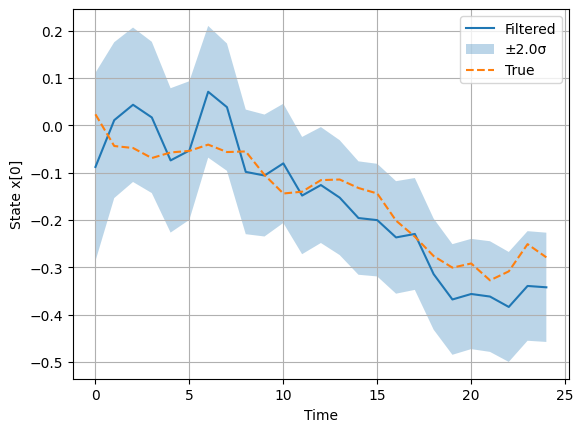

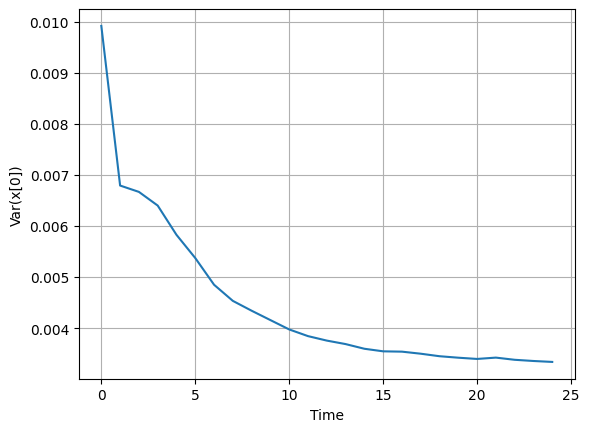

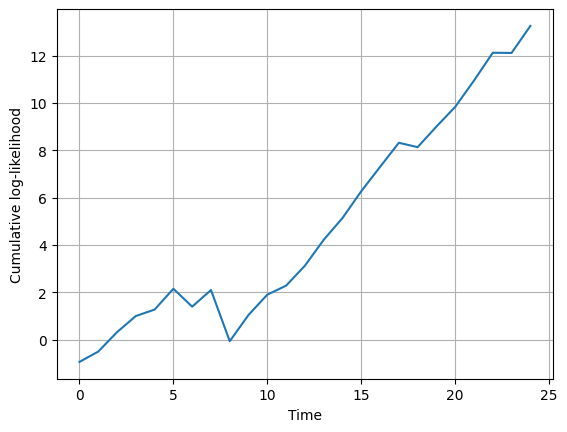

RMSE total: 0.0869988005827392


In [6]:
pf.plot_state(dim=0, X_true=X_true)
pf.plot_variance(dim=0)
pf.plot_loglikelihood()

print("RMSE total:", pf.rmse_total(X_true))

### Lokta-Volterra model

In [58]:

model_lv = LotkaVolterraSSM(
    alpha=1.5,
    beta=1.0,
    delta=1.0,
    gamma=3.0,
    dt=0.1,
    m0=np.array([1.0, 0.5]),
    P0=0.5 * np.eye(2),
    Sigma=0.01 * np.eye(2),
    Gamma=0.5 * np.eye(2),
    H=np.array([[1.0, 0.0],[0.0, 0.0]])
)

res_lv = run_experiment(model_lv, T=25, pf_particles=15000)


KF  | RMSE: 0.74608 | logL: -52.11178 | time: 0.005s
UKF | RMSE: 0.73005 | logL: -52.17072 | time: 0.025s
PF  | RMSE: 0.73482 | logL: -52.04331 | time: 62.563s


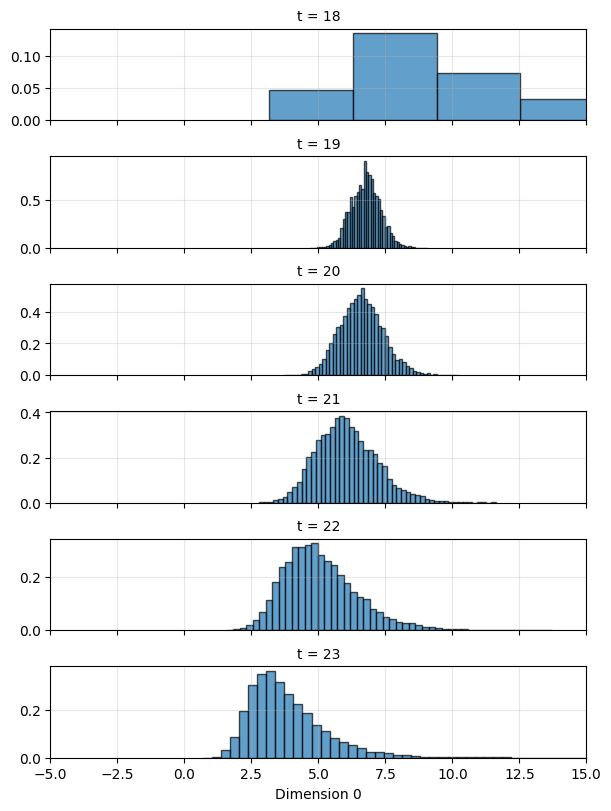

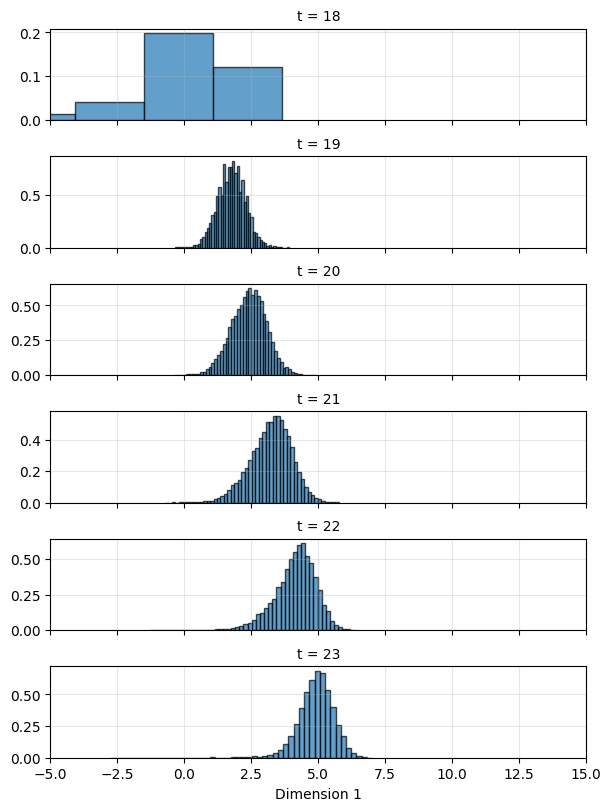

In [59]:

T_v = 18
dim = 0
lims = (-5, 15)

particles = np.array(res_lv['results']['PF']['history']['particles'])

fig, axes = plt.subplots(
    nrows=6, ncols=1,
    figsize=(6, 8),
    sharex=True,
    constrained_layout=True
)

for i, ax in enumerate(axes):
    ax.hist(
        particles[T_v + i, :, dim],
        bins=50,
        density=True,
        alpha=0.7,
        edgecolor="black"
    )
    ax.set_title(f"t = {T_v + i}", fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlim(lims)
axes[-1].set_xlabel(f"Dimension {dim}")

plt.show()

########################


dim = 1

particles = np.array(res_lv['results']['PF']['history']['particles'])

fig, axes = plt.subplots(
    nrows=6, ncols=1,
    figsize=(6, 8),
    sharex=True,
    constrained_layout=True
)

for i, ax in enumerate(axes):
    ax.hist(
        particles[T_v + i, :, dim],
        bins=50,
        density=True,
        alpha=0.7,
        edgecolor="black"
    )
    ax.set_title(f"t = {T_v + i}", fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlim(lims)
axes[-1].set_xlabel(f"Dimension {dim}")

plt.show()

del T_v, dim, lims, particles, fig, axes

### Lorenz 63' model

In [64]:
model_l63 = Lorenz63SSM(
    sigma=10.0,
    rho=28.0,
    beta=8/3,
    dt=0.025,
    m0=np.array([1.0, 1.0, 1.0]),
    P0=0.01 * np.eye(3),
    Sigma=0.1 * np.eye(3),
    Gamma=0.1 * np.eye(3), 
    H=np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0]])
)

res_l63 = run_experiment(model_l63, T=30, pf_particles=15000)


KF  | RMSE: 0.48651 | logL: -49.29242 | time: 0.007s
UKF | RMSE: 0.48745 | logL: -49.10142 | time: 0.029s
PF  | RMSE: 0.48753 | logL: -48.87913 | time: 100.597s


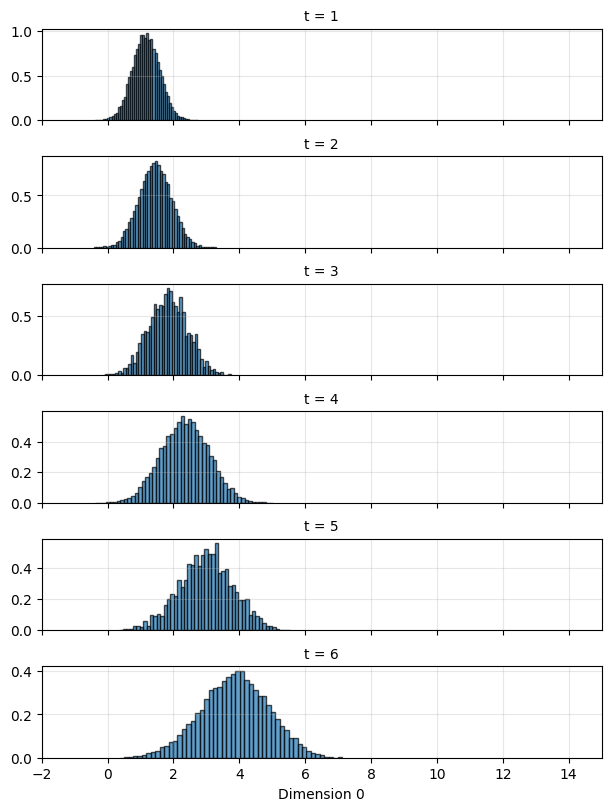

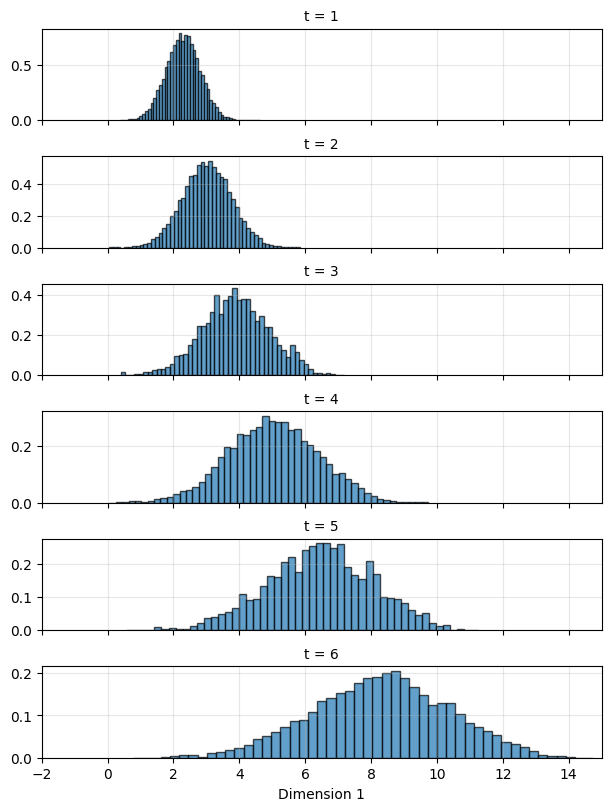

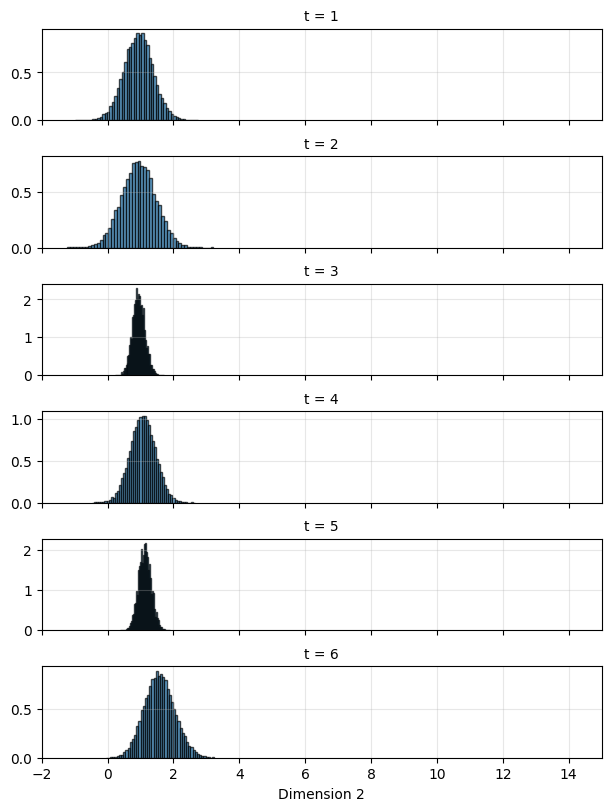

In [65]:

T_v = 1
dim = 0
lims = (-2, 15)

particles = np.array(res_l63['results']['PF']['history']['particles'])

fig, axes = plt.subplots(
    nrows=6, ncols=1,
    figsize=(6, 8),
    sharex=True,
    constrained_layout=True
)

for i, ax in enumerate(axes):
    ax.hist(
        particles[T_v + i, :, dim],
        bins=50,
        density=True,
        alpha=0.7,
        edgecolor="black"
    )
    ax.set_title(f"t = {T_v + i}", fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlim(lims)
axes[-1].set_xlabel(f"Dimension {dim}")

plt.show()

########################
dim = 1

fig, axes = plt.subplots(
    nrows=6, ncols=1,
    figsize=(6, 8),
    sharex=True,
    constrained_layout=True
)

for i, ax in enumerate(axes):
    ax.hist(
        particles[T_v + i, :, dim],
        bins=50,
        density=True,
        alpha=0.7,
        edgecolor="black"
    )
    ax.set_title(f"t = {T_v + i}", fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlim(lims)
axes[-1].set_xlabel(f"Dimension {dim}")

plt.show()


########################
dim = 2

fig, axes = plt.subplots(
    nrows=6, ncols=1,
    figsize=(6, 8),
    sharex=True,
    constrained_layout=True
)

for i, ax in enumerate(axes):
    ax.hist(
        particles[T_v + i, :, dim],
        bins=50,
        density=True,
        alpha=0.7,
        edgecolor="black"
    )
    ax.set_title(f"t = {T_v + i}", fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlim(lims)
axes[-1].set_xlabel(f"Dimension {dim}")

plt.show()

del T_v, dim, lims, particles, fig, axes